In [1]:
import numpy as np
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import multihist as mh

import GOFevaluation

import appletree as apt
from appletree import randgen
from appletree import ContextER, ContextRn220

In [2]:
apt.set_gpu_memory_usage(0.2)

## Find a sensible initial parameters set

In [3]:
pre_tree = ContextRn220()

pre_tree.log_posterior(pre_tree.par_manager.parameter_fit_array)

1724.2797026724188

In [4]:
result = pre_tree.fitting(nwalkers=200, iteration=100)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:55<00:00,  1.76s/it]


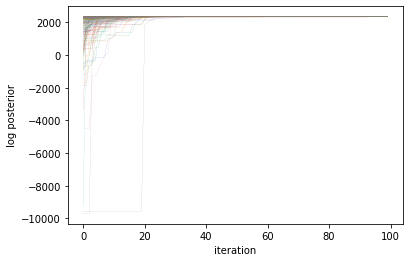

In [5]:
logp = pre_tree.sampler.get_log_prob()

for _logp in logp.T:
    plt.plot(_logp, lw=0.1)

plt.xlabel('iteration')
plt.ylabel('log posterior')
plt.show()

# Define context

In [6]:
tree = ContextER()

/home/xudc/appletree/appletree/component.py:215: UserWarning: Function name rn220_er_sim is already cached. Running compile() will overwrite it.
  warn(warning)


In [7]:
tree.print_context_summary(short=True)


LIKELIHOOD rn220_llh

BINNING

    bins_type: equiprob
    bins_on: ['cs1', 'cs2']

DATA

    file_name: /home/xudc/appletree/appletree/data/data_XENONnT_Rn220_v8_strax_v1.2.2_straxen_v1.7.1_cutax_v1.9.0.csv
    data_rate: 2058.0

MODEL

    COMPONENT 0: rn220_er
        type: simulation
        rate_par: rn220_er_rate
        pars: {'fano', 'py2', 'py4', 's2_threshold', 'nex_ni_ratio', 'py0', 'w', 'p_dpe', 'rn220_er_rate', 'g1', 'py1', 'rf0', 'py3', 'rf1', 'g2', 'gas_gain', 'drift_velocity', 'field'}

    COMPONENT 1: rn220_ac
        type: fixed
        rate_par: rn220_ac_rate
        pars: {'rn220_ac_rate'}


LIKELIHOOD ar37_llh

BINNING

    bins_type: equiprob
    bins_on: ['cs1', 'cs2']

DATA

    file_name: /home/xudc/appletree/appletree/data/data_XENONnT_Ar37_v2_1e4_events_2sig_strax_v1.2.2_straxen_v1.7.1_cutax_v1.9.0.csv
    data_rate: 9940.0

MODEL

    COMPONENT 0: ar37_er
        type: simulation
        rate_par: ar37_er_rate
        pars: {'fano', 'py2', 'py4', 's2_thres

# Fit

In [8]:
# result = tree.fitting(nwalkers=200, iteration=100)
result = tree.continue_fitting(pre_tree, iteration=100)
burn_in = 80

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:34<00:00,  3.35s/it]


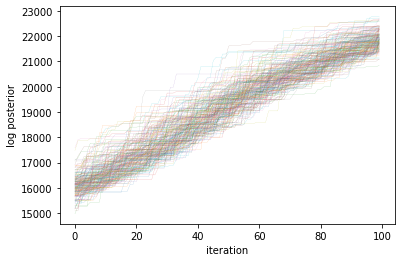

In [9]:
logp = tree.sampler.get_log_prob()

for _logp in logp.T:
    plt.plot(_logp, lw=0.1)

plt.xlabel('iteration')
plt.ylabel('log posterior')
plt.show()

# Generate templates

In [10]:
cs1, cs2, eff = tree.get_template('rn220_llh', 'rn220_er', burn_in)

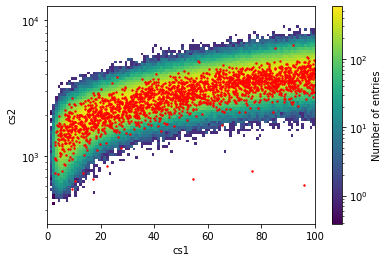

In [11]:
h, be = jnp.histogramdd(
    jnp.asarray([cs1, cs2]).T, 
    bins=(jnp.linspace(0, 100, 101), jnp.logspace(2.5, 4.1, 81)), 
    weights=eff
)

h = mh.Histdd.from_histogram(
    np.array(h), 
    be, 
    axis_names=['cs1', 'cs2']
)
h.plot(norm=LogNorm())
plt.scatter(*tree['rn220_llh'].data.T, color='r', s=2.0)
plt.yscale('log')
plt.show()

In [12]:
cs1, cs2, eff = tree.get_template('ar37_llh', 'ar37_er', burn_in)

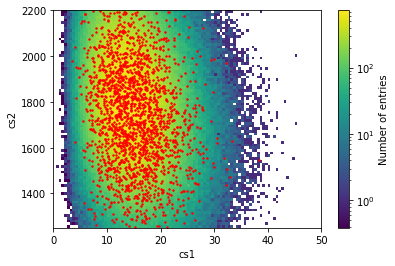

In [13]:
h, be = jnp.histogramdd(
    jnp.asarray([cs1, cs2]).T, 
    bins=(jnp.linspace(0, 50, 101), jnp.linspace(1250, 2200, 81)), 
    weights=eff
)

h = mh.Histdd.from_histogram(
    np.array(h), 
    be, 
    axis_names=['cs1', 'cs2']
)
h.plot(norm=LogNorm())
plt.scatter(*tree['ar37_llh'].data[::5].T, color='r', s=2.0)
# plt.yscale('log')
plt.show()

In [14]:
parameters = tree.get_post_parameters(burn_in)
key = randgen.get_key()
batch_size = int(1e6)

In [15]:
key, result = tree['rn220_llh']['rn220_er'].simulate(
    key, 
    batch_size, parameters
)

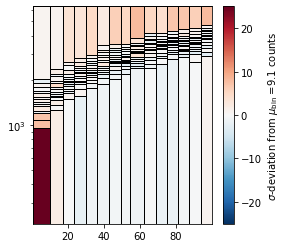

In [16]:
x_clip = tree['rn220_llh']._config['x_clip']
y_clip = tree['rn220_llh']._config['y_clip']
bin_edges = tree['rn220_llh']['rn220_er'].bins
bin_edges = [np.array(be) for be in bin_edges]

data_sample = np.array(result[:-1]).T

mask = (data_sample[:, 0] > x_clip[0])
mask &= (data_sample[:, 0] < x_clip[1])
mask &= (data_sample[:, 1] > y_clip[0])
mask &= (data_sample[:, 1] < y_clip[1])

GOFevaluation.utils.plot_equiprobable_histogram(
    data_sample=data_sample[mask][:len(tree['rn220_llh'].data)], 
    bin_edges=bin_edges.copy(), 
    order=[0, 1], 
    nevents_expected=len(tree['rn220_llh'].data), 
    plot_mode='sigma_deviation'
)
plt.yscale('log')

/opt/miniconda3/envs/XENONnT_2022.06.2/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:209: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


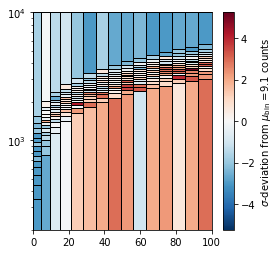

In [17]:
n, bin_edges = GOFevaluation.utils.equiprobable_histogram(
    tree['rn220_llh'].data, 
    data_sample[mask], 
    tree['rn220_llh']._config['bins'], 
    order=[0, 1], 
    plot=True, 
    nevents_expected=len(tree['rn220_llh'].data), 
    plot_xlim=x_clip,  
    plot_ylim=y_clip, 
    plot_mode='sigma_deviation'
)
plt.yscale('log')

In [18]:
key, result = tree['ar37_llh']['ar37_er'].simulate(
    key, 
    len(tree['ar37_llh'].data), parameters
)

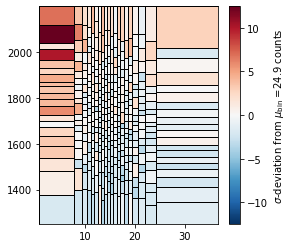

In [19]:
x_clip = tree['ar37_llh']._config['x_clip']
y_clip = tree['ar37_llh']._config['y_clip']
bin_edges = tree['ar37_llh']['ar37_er'].bins
bin_edges = [np.array(be) for be in bin_edges]

data_sample = np.array(result[:-1]).T

mask = (data_sample[:, 0] > x_clip[0])
mask &= (data_sample[:, 0] < x_clip[1])
mask &= (data_sample[:, 1] > y_clip[0])
mask &= (data_sample[:, 1] < y_clip[1])

GOFevaluation.utils.plot_equiprobable_histogram(
    data_sample=data_sample[mask][:len(tree['ar37_llh'].data)], 
    bin_edges=bin_edges.copy(), 
    order=[0, 1], 
    nevents_expected=len(tree['ar37_llh'].data), 
    plot_mode='sigma_deviation'
)

# Number of events in equal-probability binning

In [20]:
key, h = tree['rn220_llh']['rn220_er'].simulate_hist(
    key, 
    batch_size, parameters
)

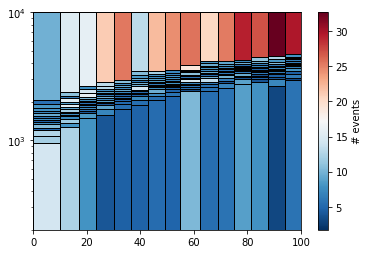

In [21]:
apt.utils.plot_irreg_histogram_2d(*tree['rn220_llh']['rn220_er'].bins, h, density=False)
plt.yscale('log')
# plt.ylim(5e2, 1e4)
plt.show()

In [22]:
key, h = tree['ar37_llh']['ar37_er'].simulate_hist(
    key, 
    batch_size, parameters
)

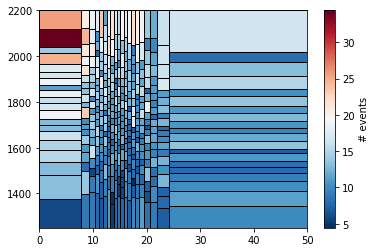

In [23]:
apt.utils.plot_irreg_histogram_2d(*tree['ar37_llh']['ar37_er'].bins, h, density=False)
plt.show()